In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [2]:
device = torch.device('cpu:0')

In [3]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [4]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [5]:
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
mask_root = nsd_root + "nsddata/ppdata/"

subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}

timestamp = 'May-13-2021_2119'
# timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'gabor_fwrf'

root_dir   = os.path.dirname(os.getcwd())
net_dir    = root_dir + "net/" 

# input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = os.path.join(root_dir, 'gabor_model_fits','S%02d'%subject,'%s_%s/'% (model_name,timestamp) )

In [6]:
# Loading the results of model fitting performed with fit_model.py

fns = os.listdir(output_dir)
fns = [fn for fn in fns if 'model_params' in fn]
print(fns)
out = torch.load(os.path.join(output_dir, fns[0]))
print(out.keys())

['model_params_allROIs']
dict_keys(['feature_table_trn', 'feature_table_val', 'sf_tuning_masks_trn', 'ori_tuning_masks_trn', 'cyc_per_stim_trn', 'orients_deg_trn', 'orient_filters_trn', 'sf_tuning_masks_val', 'ori_tuning_masks_val', 'cyc_per_stim_val', 'orients_deg_val', 'orient_filters_val', 'aperture', 'models', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'features_each_model_val', 'covar_each_model_training', 'voxel_feature_correlations_val', 'zscore_features', 'normalize_fn', 'debug'])


In [8]:
# Pulling out useful elements from the saved data
aperture = out['aperture']

feature_table_trn = out['feature_table_trn']
orient_list_trn = np.round(np.array(feature_table_trn['orientation'])/np.pi*180,1)
a,orient_ind_list_trn = np.unique(orient_list_trn,return_inverse=True)
sf_list_trn = np.array(feature_table_trn['cycles per stimulus'])
a,sf_ind_list_trn = np.unique(sf_list_trn,return_inverse=True)

feature_table_val = out['feature_table_val']
orient_list_val = np.round(np.array(feature_table_val['orientation'])/np.pi*180,1)
a,orient_ind_list_val = np.unique(orient_list_val,return_inverse=True)
sf_list_val = np.array(feature_table_val['cycles per stimulus'])
a,sf_ind_list_val = np.unique(sf_list_val,return_inverse=True)

cyc_per_stim_trn  = out['cyc_per_stim_trn']
orients_deg_trn = out['orients_deg_trn']
sf_tuning_masks_trn = out['sf_tuning_masks_trn']
ori_tuning_masks_trn = out['ori_tuning_masks_trn']
orient_filters_trn = out['orient_filters_trn']

cyc_per_stim_val  = out['cyc_per_stim_val']
orients_deg_val = out['orients_deg_val']
sf_tuning_masks_val = out['sf_tuning_masks_val']
ori_tuning_masks_val = out['ori_tuning_masks_val']
orient_filters_val = out['orient_filters_val']


voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index']
voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
best_params = out['best_params']
best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

features_each_model_val = out['features_each_model_val']
voxel_feature_correlations_val = out['voxel_feature_correlations_val']
covar_each_model_training = out['covar_each_model_training']
                                     
zscore_features = out['zscore_features']
normalize_fn = out['normalize_fn']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf_trn = len(cyc_per_stim_trn)
n_ori_trn = len(orients_deg_trn)
n_sf_val = len(cyc_per_stim_val)
n_ori_val = len(orients_deg_val)
n_voxels = np.shape(feature_weights)[0]
n_features_total_trn = np.shape(feature_weights)[1]

print(np.shape(voxel_feature_correlations_val))

(11694, 3)
(11694, 96)
(11694, 432)


In [12]:
feature_table_trn

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix)
0,3.0,12,0.000000,2.8,12.0,2.891
1,3.0,12,0.392699,2.8,12.0,2.891
2,3.0,12,0.785398,2.8,12.0,2.891
3,3.0,12,1.178097,2.8,12.0,2.891
4,3.0,12,1.570796,2.8,12.0,2.891
...,...,...,...,...,...,...
91,72.0,297,1.178097,2.8,12.0,2.891
92,72.0,297,1.570796,2.8,12.0,2.891
93,72.0,297,1.963495,2.8,12.0,2.891
94,72.0,297,2.356194,2.8,12.0,2.891


In [11]:
feature_table_val

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix)
0,3.0,12,0.000000,2.8,12.0,2.891
1,3.0,12,0.087266,2.8,12.0,2.891
2,3.0,12,0.174533,2.8,12.0,2.891
3,3.0,12,0.261799,2.8,12.0,2.891
4,3.0,12,0.349066,2.8,12.0,2.891
...,...,...,...,...,...,...
427,72.0,297,2.705260,2.8,12.0,2.891
428,72.0,297,2.792527,2.8,12.0,2.891
429,72.0,297,2.879793,2.8,12.0,2.891
430,72.0,297,2.967060,2.8,12.0,2.891


In [13]:
lambdas

array([1.00000000e-06, 7.49894209e-06, 5.62341325e-05, 4.21696503e-04,
       3.16227766e-03, 2.37137371e-02, 1.77827941e-01, 1.33352143e+00,
       1.00000000e+01])

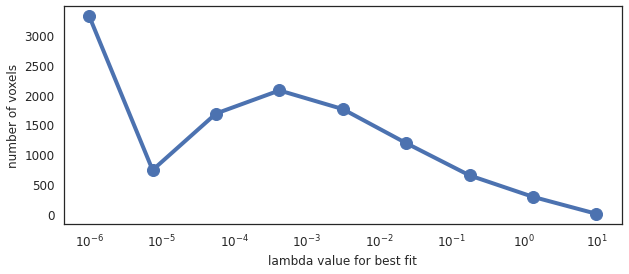

In [14]:
# Plot best lambda values for all voxels

plt.figure(figsize=(10,4))
# lambdas = np.logspace(0.,5.,9, dtype=np.float32)
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');

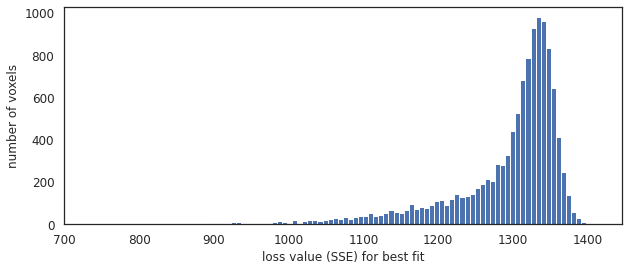

In [15]:
# Plot best loss values for all voxels

plt.figure(figsize=(10,4))
plt.hist(best_losses,100)
plt.xlabel('loss value (SSE) for best fit');
plt.ylabel('number of voxels');

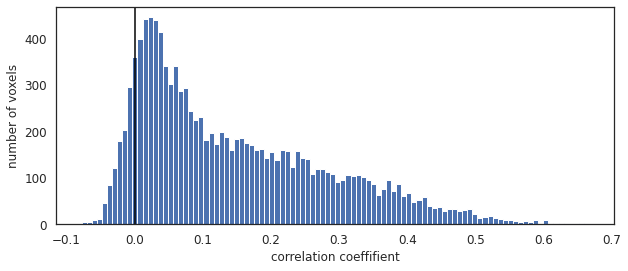

In [16]:
# Plot correlation coefficient for validation set, each voxel.

plt.figure(figsize=(10,4))
plt.hist(val_cc,100)
plt.xlabel('correlation coeffifient');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')


Text(0, 0.5, 'validation set rho')

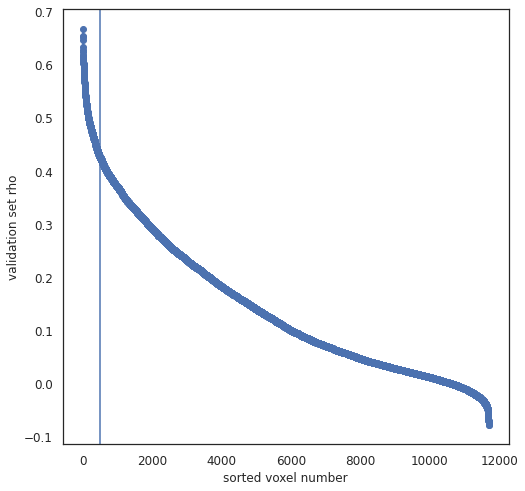

In [17]:
# Plot sorted correlation coefficients

plt.figure(figsize=(8,8))
# best_cc_vals = np.argsort(val_cc)
plt.plot(np.sort(val_cc)[::-1],'-o')
plt.axvline(500)
plt.xlabel('sorted voxel number')
plt.ylabel('validation set rho')

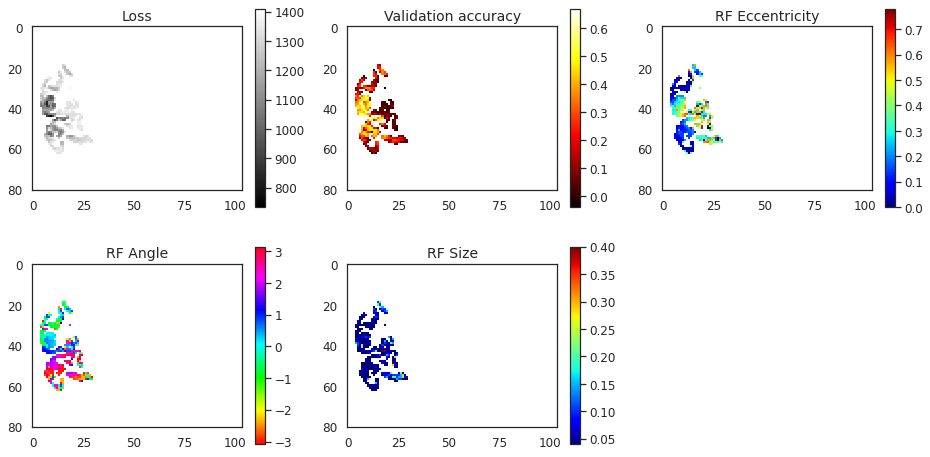

In [18]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

from src.file_utility import view_data

volume_loss = view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = view_data(brain_nii_shape, voxel_idx, val_cc, save_to=output_dir+"val_cc")
volume_ecc  = view_data(brain_nii_shape, voxel_idx, best_ecc, save_to=output_dir+"rf_ecc")
volume_ang  = view_data(brain_nii_shape, voxel_idx, best_ang, save_to=output_dir+"rf_ang")
volume_size = view_data(brain_nii_shape, voxel_idx, best_size, save_to=output_dir+"rf_size")

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

In [21]:
# Assessing spatial frequency and orientation tuning

allcorrs_reshaped = np.reshape(voxel_feature_correlations_val, [n_voxels, n_ori_val, n_sf_val], order='F')

mean_orient_corrs = np.mean(allcorrs_reshaped, axis=2)
print(np.shape(mean_orient_corrs))
mean_sf_corrs = np.mean(allcorrs_reshaped, axis=1)
print(np.shape(mean_sf_corrs))

max_orient_corr_ind = np.argmax(mean_orient_corrs, axis=1)
preferred_ori_corrs = orients_deg_val[max_orient_corr_ind]

max_sf_corr_ind = np.argmax(mean_sf_corrs, axis=1)
preferred_sf_corrs = cyc_per_stim_val[max_sf_corr_ind]



allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori_trn, n_sf_trn], order='F')

mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

max_orient_weight_ind = np.argmax(mean_orient_weights, axis=1)
preferred_ori_weights = orients_deg_trn[max_orient_weight_ind]

max_sf_weight_ind = np.argmax(mean_sf_weights, axis=1)
preferred_sf_weights = cyc_per_stim_trn[max_sf_weight_ind]


(11694, 36)
(11694, 12)
(11694, 8)
(11694, 12)


In [22]:
# double check that the reshaping was done correctly
sf=0
oo=0
print(allw_reshaped[0,:,sf])
print(feature_weights[0,sf_tuning_masks_trn[sf]])
print(allcorrs_reshaped[0,:,sf])
print(voxel_feature_correlations_val[0,sf_tuning_masks_val[sf]])

print(allw_reshaped[0,oo,:])
print(feature_weights[0,ori_tuning_masks_trn[oo]])
print(allcorrs_reshaped[0,oo,:])
print(voxel_feature_correlations_val[0,ori_tuning_masks_val[oo]])


[-1.7690328   2.3851278   0.48875287  0.5401935  -2.4559674   0.59064114
  0.7823119   0.9352709 ]
[-1.7690328   2.3851278   0.48875287  0.5401935  -2.4559674   0.59064114
  0.7823119   0.9352709 ]
[ 0.01886604  0.02382311  0.02911426  0.03071147  0.02936724  0.02558179
  0.02095671  0.01689643  0.01240771  0.00827287  0.00626483  0.00146222
 -0.00475953 -0.01378095 -0.02414479 -0.03367195 -0.03775054 -0.03682308
 -0.03352471 -0.02760377 -0.01956728 -0.01032477 -0.00025852  0.00170917
 -0.003613   -0.00914924 -0.01289313 -0.00780846  0.0058204   0.02548305
  0.04045347  0.04447936  0.03615731  0.02533782  0.02024624  0.0181406 ]
[ 0.01886604  0.02382311  0.02911426  0.03071147  0.02936724  0.02558179
  0.02095671  0.01689643  0.01240771  0.00827287  0.00626483  0.00146222
 -0.00475953 -0.01378095 -0.02414479 -0.03367195 -0.03775054 -0.03682308
 -0.03352471 -0.02760377 -0.01956728 -0.01032477 -0.00025852  0.00170917
 -0.003613   -0.00914924 -0.01289313 -0.00780846  0.0058204   0.0254830

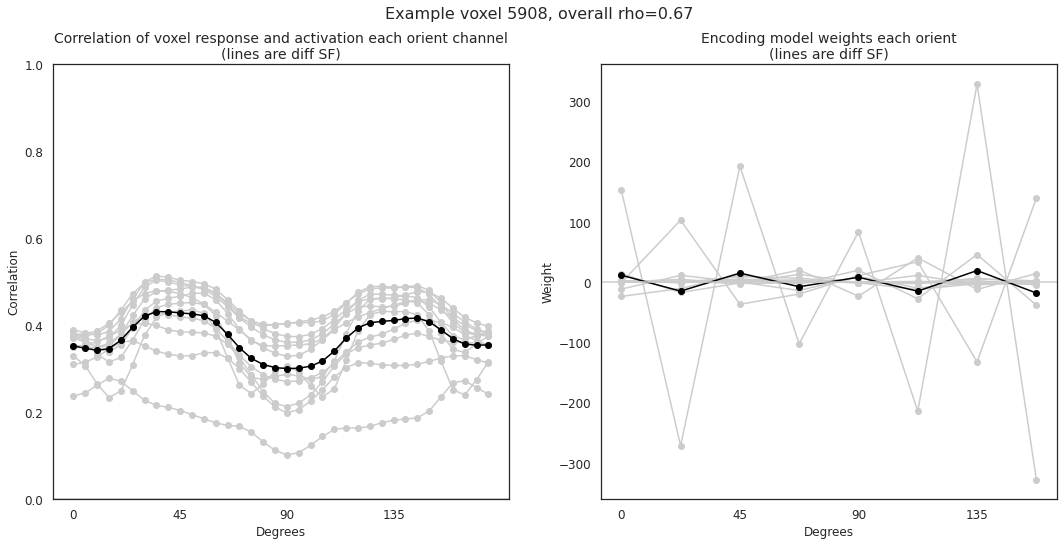

In [23]:
# Plotting orientation tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(orients_deg_val, allcorrs_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg_val,  mean_orient_corrs[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each orient channel\n(lines are diff SF)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(orients_deg_trn, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg_trn, mean_orient_weights[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient\n(lines are diff SF)')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([-1,1])

plt.suptitle('Example voxel %d, overall rho=%.2f'%( vidx, val_cc[vidx]),fontsize=16);

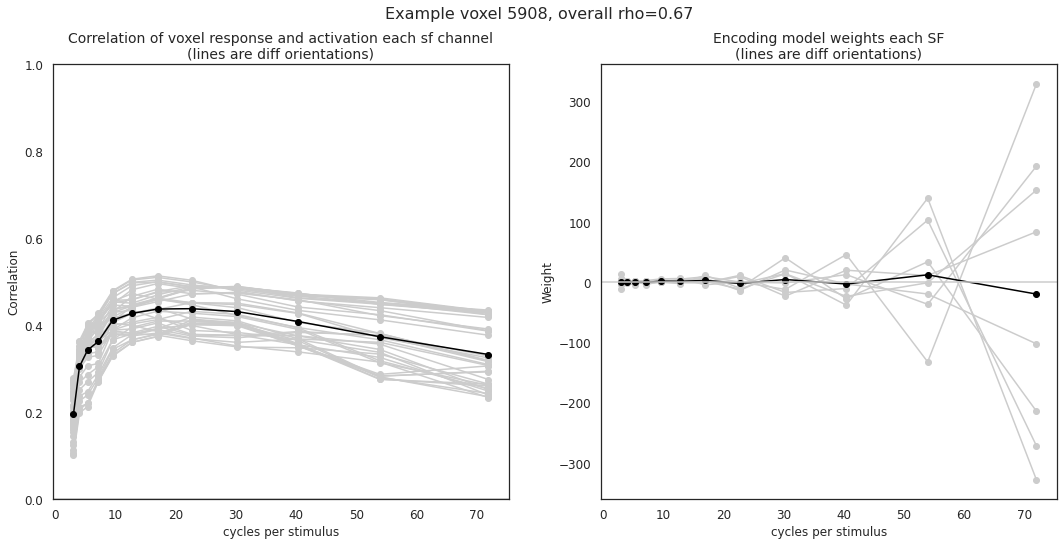

In [24]:
# Plotting SF tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(cyc_per_stim_val, np.transpose(allcorrs_reshaped[vidx,:,:]),'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_stim_val, mean_sf_corrs[vidx,:],'-o',color='k')
plt.xlabel('cycles per stimulus')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each sf channel\n(lines are diff orientations)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(cyc_per_stim_trn, np.transpose(allw_reshaped[vidx,:,:]),'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_stim_trn, mean_sf_weights[vidx,:],'-o',color='k')
plt.xlabel('cycles per stimulus')
plt.ylabel('Weight')
plt.title('Encoding model weights each SF\n(lines are diff orientations)')
plt.axhline(0, color=[0.8, 0.8, 0.8])

plt.suptitle('Example voxel %d, overall rho=%.2f'%(vidx, val_cc[vidx]),fontsize=16);

In [27]:
# For same example voxel, get its actual pRF parameters
aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
n_sizes = 8

from src.rf_grid import model_space_pyramid
# models is three columns, x, y, sigma
models = model_space_pyramid(logspace(n_sizes)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)    

best_model_ind = np.where(np.sum(models==best_models[vidx],axis=1)==3)[0][0]
print(models[best_model_ind])
print(best_models[vidx])

[0.26052632 0.37631579 0.04      ]
[0.26052632 0.37631579 0.04      ]


Text(0.5, 1.0, 'training set covariance matrix')

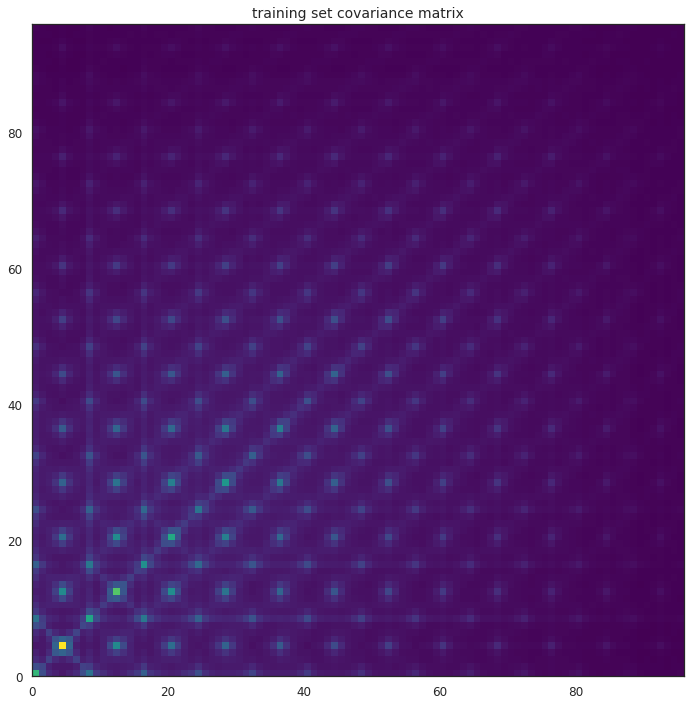

In [33]:
# visualizing covariance among features in the training set data - before and after z-scoring
# all features are nori*nsf = 432 total
import scipy
plt.figure(figsize=(12,12));

# plt.subplot(1,2,1)

# features_actual = features_each_model_val[:,:,best_model_ind]
covariance = covar_each_model_training[:,:,best_model_ind]
plt.pcolormesh(covariance)
# plt.colorbar()
plt.axis('square')
plt.title('training set covariance matrix')
# plt.subplot(1,2,2)

# features_actual = scipy.stats.zscore(features_each_model_val[:,:,best_model_ind], axis=0)
# covariance = np.cov(np.transpose(features_actual))
# plt.pcolormesh(covariance)
# plt.colorbar()
# plt.axis('square')
# plt.title('z-score each feature across images')
# plt.xticks(np.arange(0,35,9),labels=np.arange(0,179,45))
# plt.yticks(np.arange(0,35,9),labels=np.arange(0,179,45))

In [30]:
np.shape(covariance)

(96, 96)

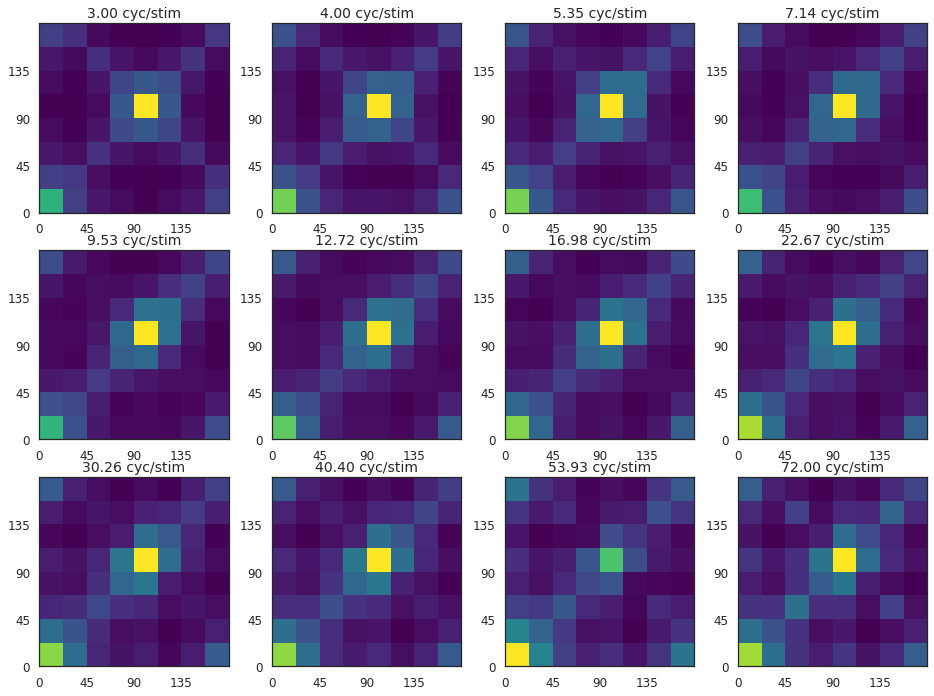

In [39]:
# visualizing just one SF at a time...

# trn_features_actual = scipy.stats.zscore(trn_features[:,0:n_features])
covariance = covar_each_model_training[:,:,best_model_ind]
plt.figure(figsize=(16,16));
# plotting one sf at a time to see within-sf orientation covariance...
for sf2plot in range(n_sf_trn):

    plt.subplot(4,4,sf2plot+1)
    cov2plot = covariance[sf_tuning_masks_trn[sf2plot],:]
    cov2plot = cov2plot[:,sf_tuning_masks_trn[sf2plot]]
    plt.pcolormesh(cov2plot)
#     plt.colorbar()
    plt.axis('square')
    plt.xticks(np.arange(0,n_ori_trn,n_ori_trn/4),labels=np.arange(0,179,45))
    plt.yticks(np.arange(0,n_ori_trn,n_ori_trn/4),labels=np.arange(0,179,45))
    plt.title('%.2f cyc/stim'%(cyc_per_stim_trn[sf2plot]))

In [36]:
sf_tuning_masks_trn[sf2plot]

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

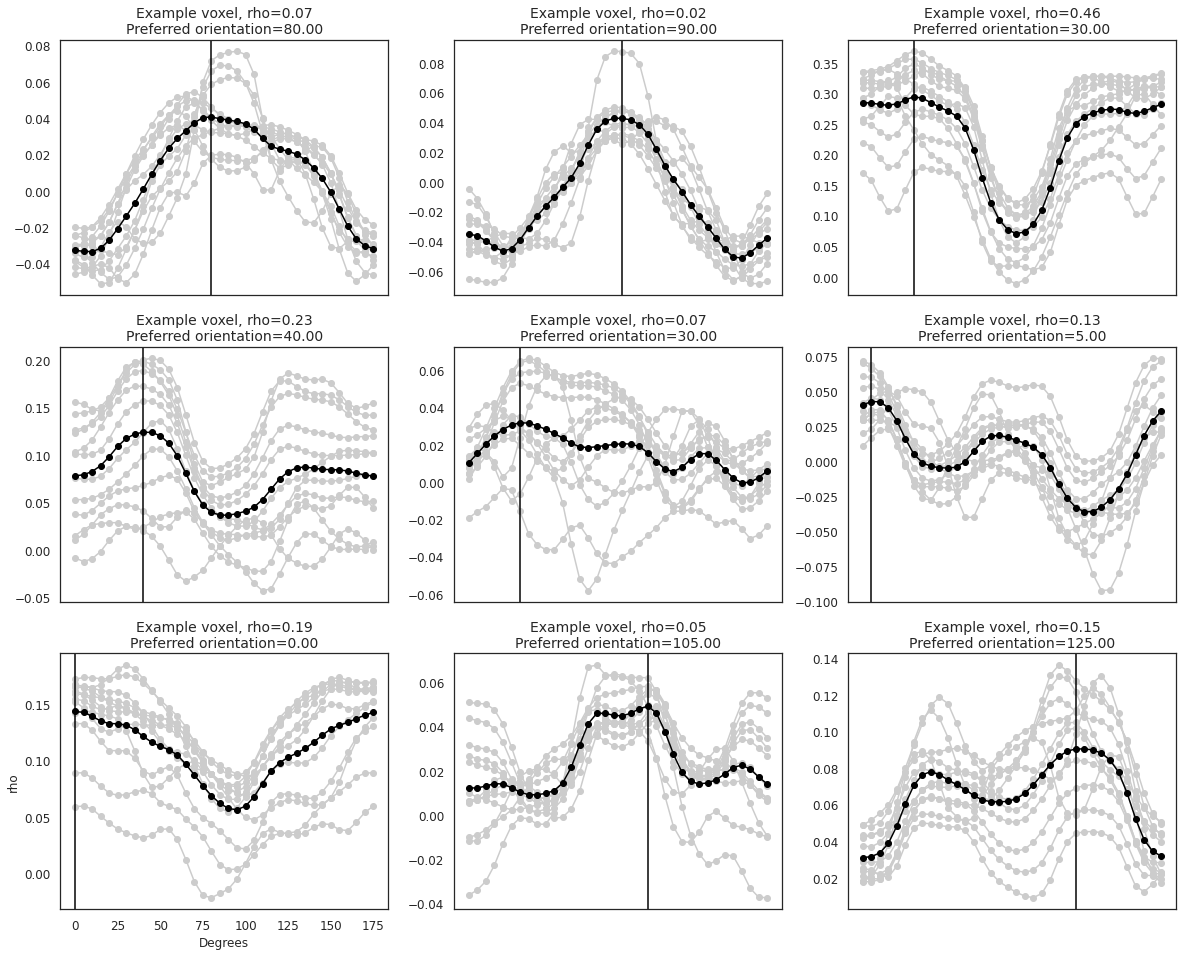

In [40]:
# Plotting orient tuning for several example voxels (based on correlation of resp with orientation channel activation)
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(orients_deg_val, allcorrs_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg_val, mean_orient_corrs[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_ori_corrs[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred orientation=%.2f'%(val_cc[vv], preferred_ori_corrs[vv]))


[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175.]
[696 345 173 154 162 196 398 573 329 311 381 483 313 215 206 204 248 434
 753 451 254 195 184 163 258 398 299 292 415 695 435 229 173 162 174 343]
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[1732 1100 3257  846  380  844 2399 1136]


Text(0.5, 1.0, 'Based on encoding model weights')

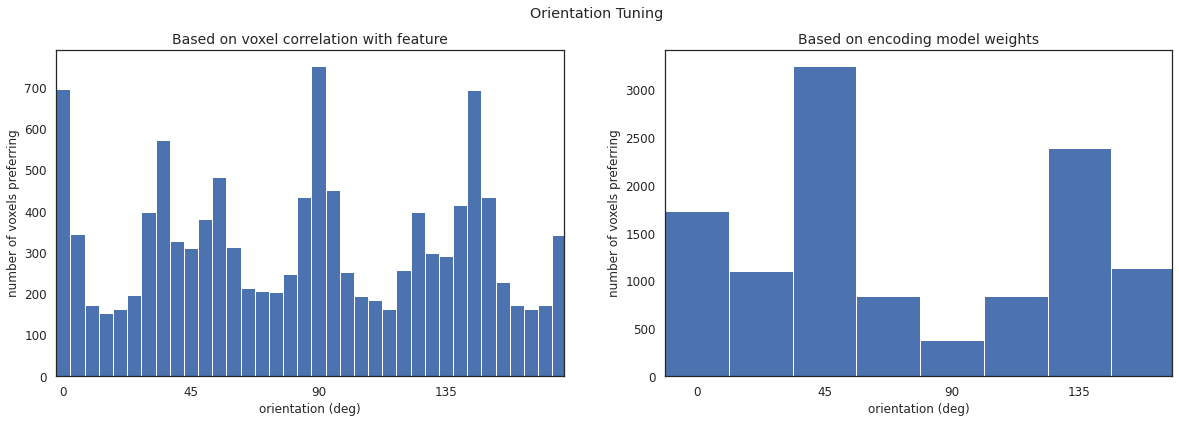

In [88]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
h = plt.hist(np.round(preferred_ori_corrs,0), bins=np.arange(0,180+180/n_ori_val,180/n_ori_val) );
unvals, counts = np.unique(preferred_ori_corrs, return_counts=True)
print(unvals)
print(counts)

plt.xticks(np.arange(0,179,45)+180/n_ori_val/2, np.arange(0,179,45))
plt.xlim([0,179])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.suptitle('Orientation Tuning')
plt.title('Based on voxel correlation with feature')

plt.subplot(1,2,2)
h = plt.hist(np.round(preferred_ori_weights,1), bins=np.arange(0,180+180/n_ori_trn,180/n_ori_trn) );
unvals, counts = np.unique(preferred_ori_weights, return_counts=True)
print(unvals)
print(counts)

plt.xticks(np.arange(0,179,45)+180/n_ori_trn/2, np.arange(0,179,45))
plt.xlim([0,179])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.suptitle('Orientation Tuning')
plt.title('Based on encoding model weights')

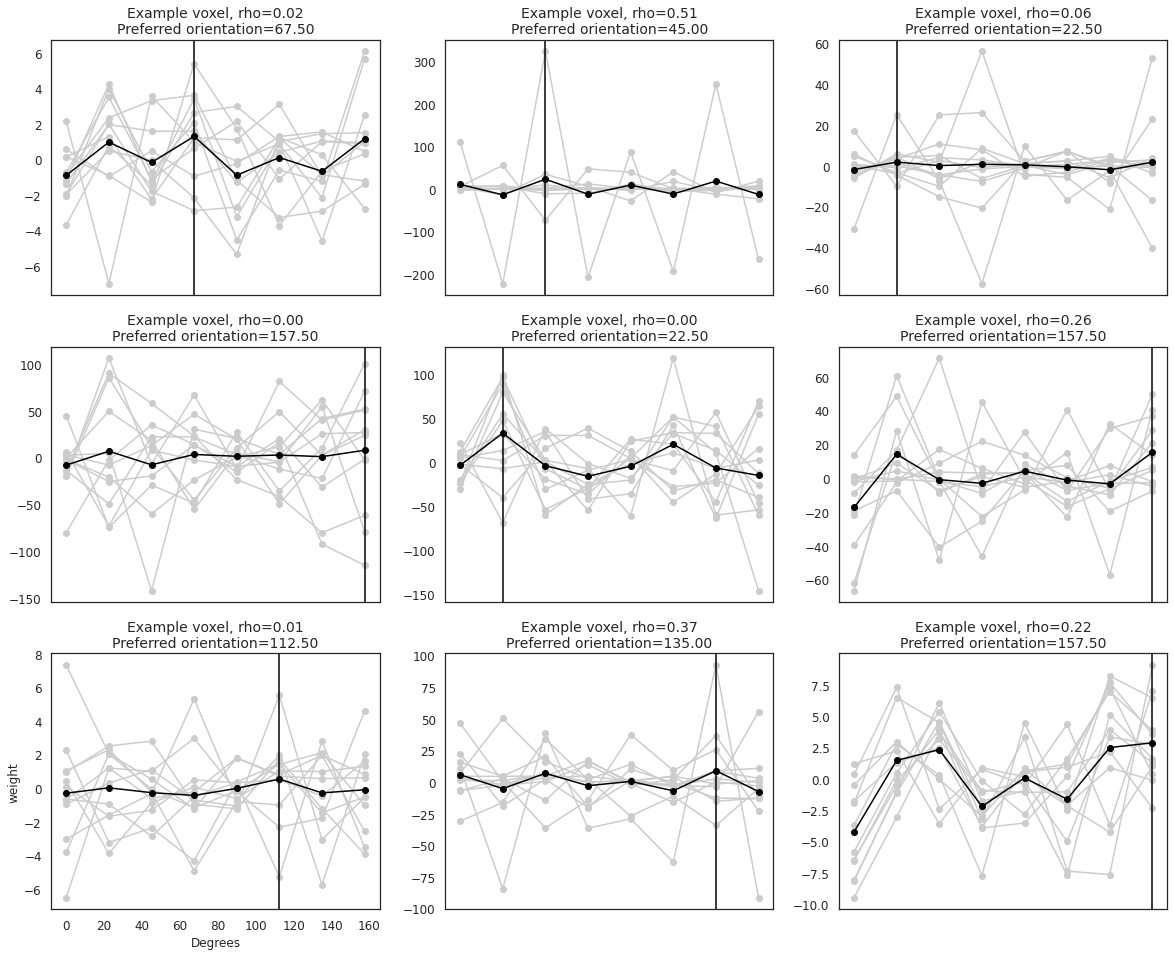

In [42]:
# Plotting orientation tuning for several example voxels (based on encoding model wts)
n2plot = 9
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(orients_deg_trn, allw_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg_trn, mean_orient_weights[vv,:],'-o',color='k')  
    plt.axvline(preferred_ori_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred orientation=%.2f'%(val_cc[vv], preferred_ori_weights[vv]))


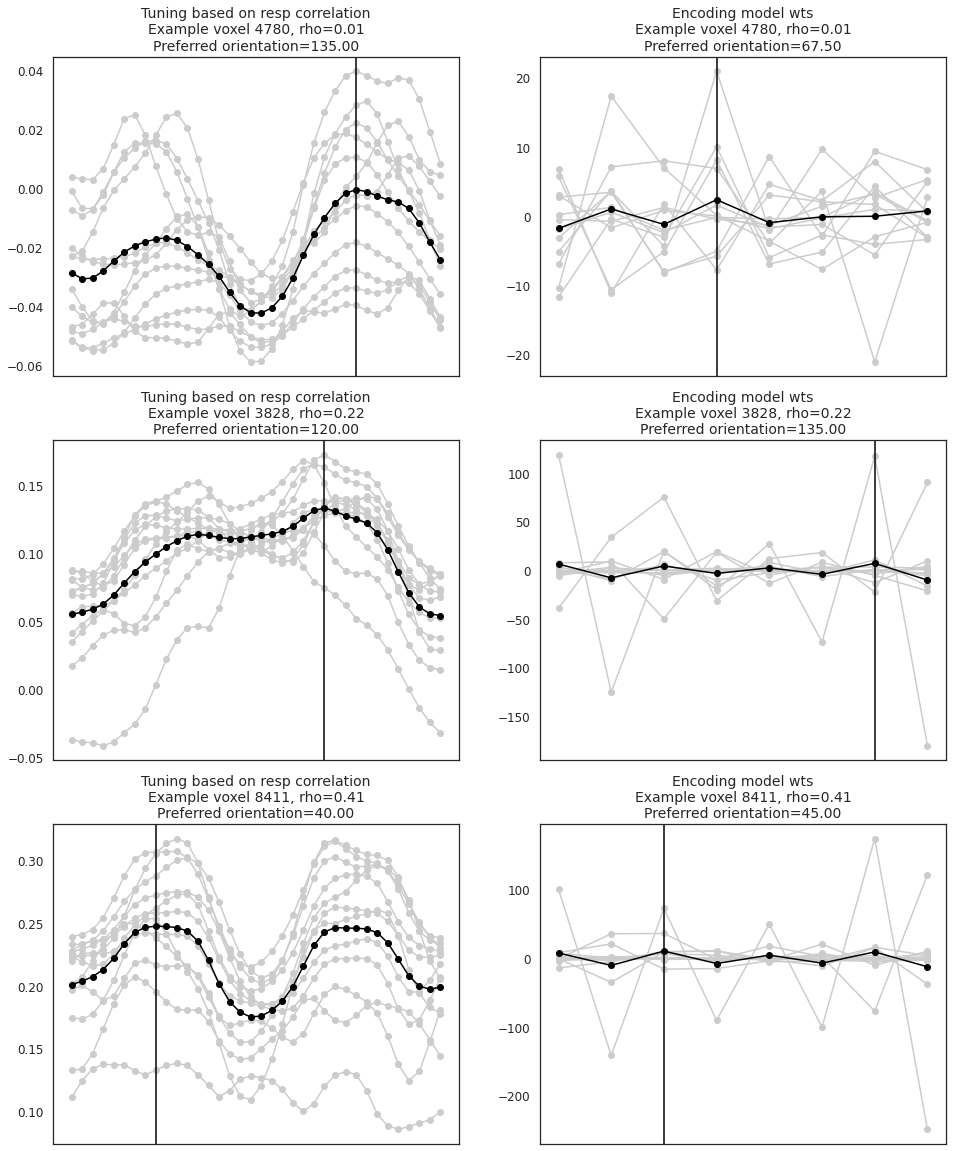

In [90]:
# Compare two methods of tuning side by side
n2plot = 3
npx = n2plot
npy = 2
# npx = int(np.ceil(np.sqrt(n2plot)))
# npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(16,20))
for vi, vv in enumerate(vox2plot):   

    plt.subplot(npx, npy, (2*vi)+1)   
    plt.plot(orients_deg_val, allcorrs_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg_val, mean_orient_corrs[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_ori_corrs[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Tuning based on resp correlation\nExample voxel %d, rho=%.2f\nPreferred orientation=%.2f'%(vv, val_cc[vv], preferred_ori_corrs[vv]))

    plt.subplot(npx, npy, (2*vi)+2)   
    plt.plot(orients_deg_trn, allw_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg_trn, mean_orient_weights[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_ori_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Encoding model wts\nExample voxel %d, rho=%.2f\nPreferred orientation=%.2f'%(vv, val_cc[vv], preferred_ori_weights[vv]))


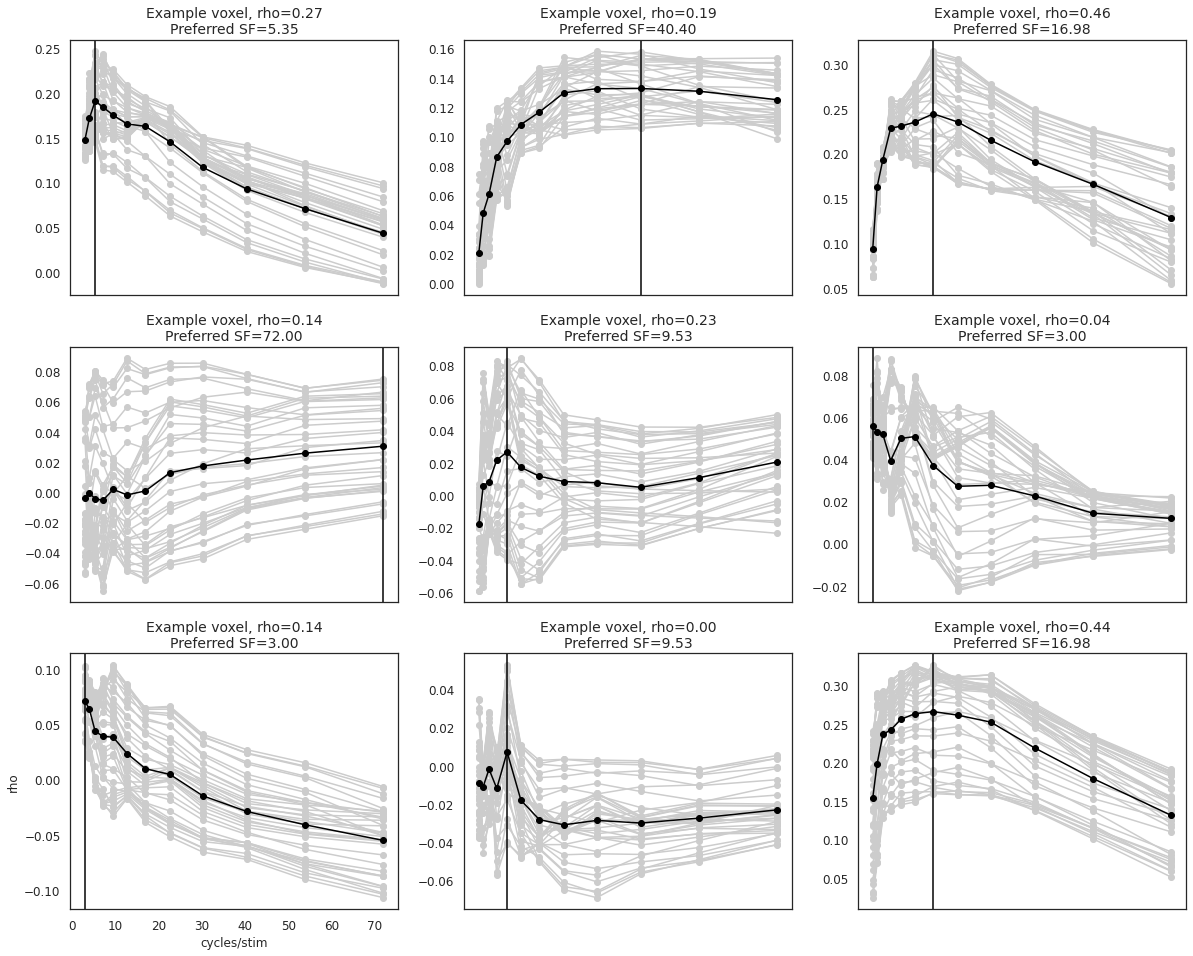

In [91]:
# Plotting SF tuning for several example voxels (based on correlation of resp with SF channel activation)
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(cyc_per_stim_val, np.transpose(allcorrs_reshaped[vv,:,:]),'-o',color=[0.8, 0.8, 0.8])
    plt.plot(cyc_per_stim_val, mean_sf_corrs[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_sf_corrs[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('cycles/stim')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred SF=%.2f'%(val_cc[vv], preferred_sf_corrs[vv]))


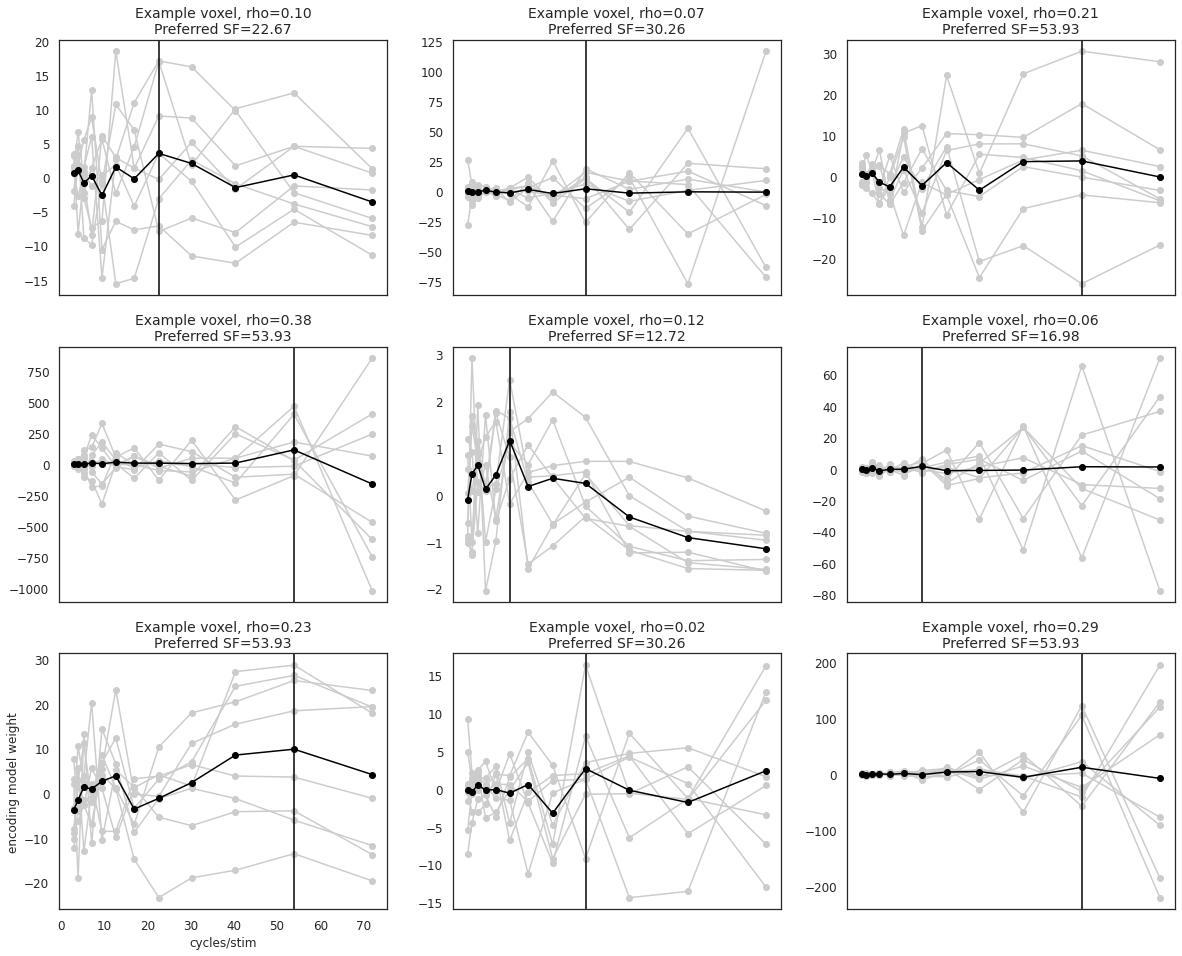

In [93]:
# Plotting SF tuning for several example voxels (based on encoding model wts);
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(cyc_per_stim_trn, np.transpose(allw_reshaped[vv,:,:]),'-o',color=[0.8, 0.8, 0.8])
    plt.plot(cyc_per_stim_trn, mean_sf_weights[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_sf_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('cycles/stim')
        plt.ylabel('encoding model weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    plt.title('Example voxel, rho=%.2f\nPreferred SF=%.2f'%(val_cc[vv], preferred_sf_weights[vv]))


[ 3.         4.0049305  5.34649    7.1374407  9.528318  12.720084
 16.98102   22.669268  30.262949  40.400337  53.933517  72.       ]
[1334  884 1144  848  957  888  752  882  699  778  900 1628]
[ 3.         4.0049305  5.34649    7.1374407  9.528318  12.720084
 16.98102   22.669268  30.262949  40.400337  53.933517  72.       ]
[  47   79  114  184  319  548  614  797 1231 1668 3773 2320]


Text(0.5, 0.98, 'Spatial Frequency Tuning')

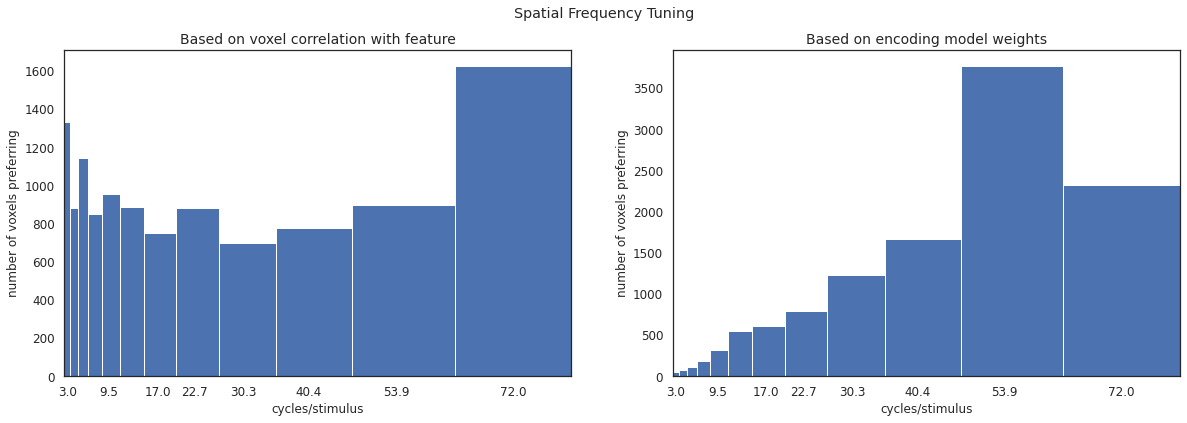

In [118]:
# Plot histogram of the "tuning preferences" based on correlation coefficient

better_bin_edges = [cyc_per_stim_val[ii] - np.diff(cyc_per_stim_val[ii-1:ii+1])/2 for ii in np.arange(1,len(cyc_per_stim_val))]
better_bin_edges.insert(0, cyc_per_stim_val[0] - np.diff(cyc_per_stim_val[0:2])/2)
better_bin_edges.append(cyc_per_stim_val[-1] + np.diff(cyc_per_stim_val[-2:])/2)
better_bin_edges = np.squeeze(better_bin_edges)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
h = plt.hist(np.round(preferred_sf_corrs,0), bins=better_bin_edges );
unvals, counts = np.unique(preferred_sf_corrs, return_counts=True)
print(unvals)
print(counts)
plt.xticks(np.round(cyc_per_stim_val[[0,4]+list(np.arange(6,n_sf_val))],1))
plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
plt.xlabel('cycles/stimulus')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')

plt.subplot(1,2,2)
h = plt.hist(np.round(preferred_sf_weights,1), bins=better_bin_edges );
unvals, counts = np.unique(preferred_sf_weights, return_counts=True)
print(unvals)
print(counts)
plt.xticks(np.round(cyc_per_stim_val[[0,4]+list(np.arange(6,n_sf_val))],1))
plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
plt.xlabel('cycles/stimulus')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')

plt.suptitle('Spatial Frequency Tuning')
